In [2]:
import math
import torch
import mdtraj as md
import nglview as nv
import numpy as np

from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

from adaptive_sampling.processing_tools import mbar
from adaptive_sampling.processing_tools.utils import DeltaF_fromweights

In [13]:
# UNITS

# conversions
J_to_atomic = 1.0 / 4.359744e-18
atomic_to_kJmol = 2625.499639
kJ_to_kcal = 0.239006
atomic_to_K = 315775.04e0
BOHR_to_ANGSTROM = 0.52917721092e0
BOHR_to_NANOMETER = BOHR_to_ANGSTROM / 10.0
DEGREES_per_RADIAN = 180.0 / math.pi
atomic_to_kg = 1.66054e-27
atomic_to_fs = 1.0327503e0
atomic_to_bar = 2.9421912e8

# constants
kB_in_SI = 1.380648e-23
R_in_SI = 8.314
kB_in_atomic = kB_in_SI * J_to_atomic
h_in_SI = 6.62607004e-34

blue = (70 / 255, 110 / 255, 250 / 255)

In [4]:
# OURS
molecule = "cln025"
seed = "0"
method = "ours"
date = "0830_162145"

# TDA
# molecule = "cln025"
# seed = "0"
# method = "tda"
# date = "0827_081656"

simulation_dir = Path(f"/home/shpark/prj-mlcv/lib/bioemu/opes/simulations/{molecule}/{method}/{date}")
traj_path = simulation_dir / "analysis" / f"{seed}_tc.xtc"
gro_path = simulation_dir / f"{seed}.gro"

# Load Trajectory

In [19]:
# gro_protein_idx = md.load(gro_path).topology.select("protein")
traj = md.load_xtc(
    traj_path,
    top="/home/shpark/prj-mlcv/lib/bioemu/opes/data/CLN025/folded.pdb",
    # atom_indices=gro_protein_idx
)
traj.center_coordinates()
print(traj)

<mdtraj.Trajectory with 120001 frames, 166 atoms, 10 residues, and unitcells>


In [20]:
view = nv.show_mdtraj(traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget(max_frame=120000)

In [21]:
view.frame = 1

# Energy

### 5. Delta F and PMF calculation
We also provide a single example for the case mentioned above.
We followed the metadynamics grid range and sigma values for each CV from Table S1 in the SI.
Note that we are printing to the `COLVAR` file every 1000 steps (2 ps), so `--skip-steps` of 50000 corresponds to 100 ns.
```bash
python scripts/compute_pmf.py \
    --colvar-file simulations/enhanced/TDA/nvt_0/COLVAR \
    --cv-thresh -8.5 8.5 \
    --sigma 0.20 \
    --skip-steps 50000 \
    --save-path simulations/enhanced/TDA/nvt_0
```
This script will generate two files in the `--save-path` directory:
- `Delta_Fs.log` contains the time (in ns) and the delta F value (in kJ/mol) at each time point.
- `pmf.log` contains the CV grid and the PMF value (in kJ/mol) at each grid point.

In [21]:
# Load and predefine components
cv_min = -1
cv_max = 1
cv_avg = (cv_max + cv_min) / 2
cv_thresh = [
    cv_min,
    cv_avg,
    cv_max,
]

sigma = 0.20
equil_temp = 340
ns_per_step = 0.002
unit_steps = 2500
skip_steps = 5000

save_path = Path(f"{simulation_dir}/{seed}")
colvar_path = Path(f"{simulation_dir}/{seed}/COLVAR")

## Delta F

### Library

In [22]:
# Load the normal and extended system trajectory (COLVAR file)
traj_dat = np.genfromtxt(colvar_path, skip_header=1)
time = traj_dat[:, 0]
cv = traj_dat[:, 1]
bias = traj_dat[:, 2]
total_steps = len(traj_dat)
step_grid = np.arange(
    skip_steps + unit_steps, total_steps + 1, unit_steps
)

print("< Trajectory information >")
print(f"- Total steps: {total_steps}")
print(f"- Skip steps: {skip_steps}")
print(f"- Unit steps: {unit_steps}")

< Trajectory information >
- Total steps: 200001
- Skip steps: 5000
- Unit steps: 2500


In [23]:
R = 0.008314462618  # kJ/mol/K
beta = 1.0 / (R * equil_temp)
W = np.exp(beta * bias)  
cv_grid = np.arange(cv.min(), cv.max() + sigma / 2, sigma)

print(step_grid)
print(cv_grid)

[  7500  10000  12500  15000  17500  20000  22500  25000  27500  30000
  32500  35000  37500  40000  42500  45000  47500  50000  52500  55000
  57500  60000  62500  65000  67500  70000  72500  75000  77500  80000
  82500  85000  87500  90000  92500  95000  97500 100000 102500 105000
 107500 110000 112500 115000 117500 120000 122500 125000 127500 130000
 132500 135000 137500 140000 142500 145000 147500 150000 152500 155000
 157500 160000 162500 165000 167500 170000 172500 175000 177500 180000
 182500 185000 187500 190000 192500 195000 197500 200000]
[-0.995803 -0.795803 -0.595803 -0.395803 -0.195803  0.004197  0.204197
  0.404197  0.604197  0.804197  1.004197]


In [24]:
# Constants
R = 8.314462618  # J/mol·K
T = 340.0  # Temperature in Kelvin
RT = R * T / 1000.0  # RT in kJ/mol

# Load OPES data (example: from COLVAR file)
xi_traj = np.loadtxt(colvar_path, usecols=1)  # CV values
opes_bias = np.loadtxt(colvar_path, usecols=2)  # OPES.bias values

# Compute unbiased Boltzmann weights
weights = np.exp(opes_bias / RT)
weights /= weights.sum()  # Normalize weights

# Define reactant, TS, and product regions
cv_thresh = [-1.0, 0.0, 1.0]  # Example boundaries for R_min, TS, P_max

# Compute free energy difference
dA = DeltaF_fromweights(xi_traj, weights, cv_thresh, T=T)
print(f"Free energy difference: {dA:.3f} kJ/mol")

Free energy difference: -5.558 kJ/mol


In [25]:
# Compute DeltaFs

Delta_Fs = []
for current_step in tqdm(step_grid):
	cv_t = cv[skip_steps:current_step]
	W_t  = W[skip_steps:current_step]

	Delta_F = DeltaF_fromweights(
		xi_traj=cv_t,
		weights=W_t,
		cv_thresh=cv_thresh,
		T=equil_temp,
	)
	Delta_Fs.append(Delta_F)

Delta_Fs = np.array(Delta_Fs)

100%|██████████| 78/78 [00:00<00:00, 1618.57it/s]


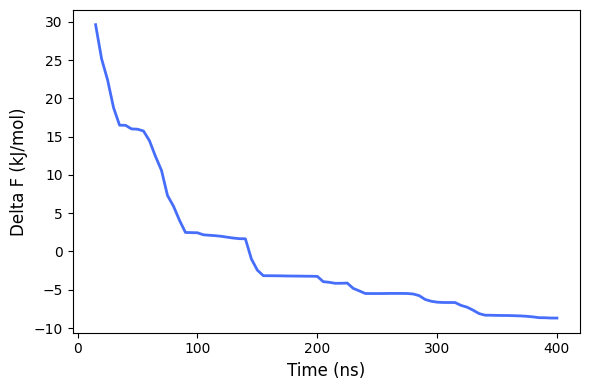

In [26]:
time_points = step_grid * ns_per_step
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
plt.plot(
    time_points, Delta_Fs,
    color=blue, linewidth=2,
)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.xlabel("Time (ns)", fontsize=12)
plt.ylabel("Delta F (kJ/mol)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("pmf.png", dpi=300)
plt.show()

## PMF

In [11]:
# Compute PMF
pmf, _ = mbar.pmf_from_weights(
    cv_grid,
    cv,
    W,
    equil_temp=equil_temp
)
pmf -= pmf.min()
# np.savetxt("pmf.log", [cv_grid, pmf], fmt="%.6f")

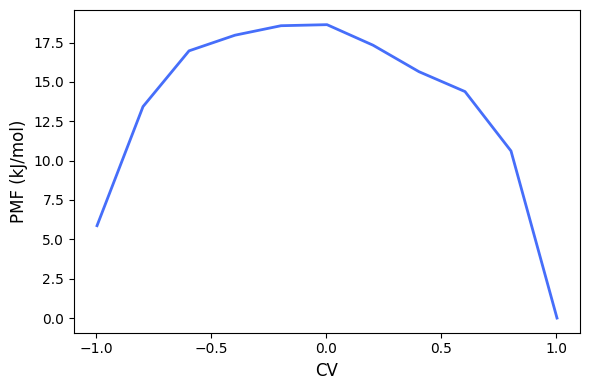

In [18]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
plt.plot(
    cv_grid, pmf,
    color=blue, linewidth=2,
)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
plt.xlabel("CV", fontsize=12)
plt.ylabel("PMF (kJ/mol)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("pmf.png", dpi=300)
plt.show()

# Fraction contact

In [2]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from typing import Optional, Sequence, Tuple, Union

def plot_fractional_contacts_ffp(
    traj_or_path: Union[str, md.Trajectory],
    top_or_ref: Optional[Union[str, md.Trajectory]] = None,
    *,
    seq_separation: int = 7,          # long-range: |i-j| >= 7
    ca_cutoff_A: float = 10.0,        # native if CA–CA <= 10 Å in the folded ref
    require_fraction_in_folded: Optional[float] = None,
    folded_mask: Optional[Sequence[bool]] = None,
    beta_Ainv: float = 5.0,           # sharpness (1/Å); 5 Å^-1 is common
    eta_A: float = 0.0,               # small shift (Å), set >0 to be lenient
    balance_by_residue: bool = False, # if True, average per-residue first (optional variant)
    ax: Optional[plt.Axes] = None,
    label: Optional[str] = None,
    save_path: Optional[str] = None,
    show: bool = False,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Fractional native contacts Q(t) per the Fast Folding Proteins paper (residue CA–CA contacts).

    Contact set S:
        - Use only Cα atoms (one per residue).
        - Pairs with sequence separation >= `seq_separation`.
        - Mark (i, j) native if CA–CA distance in the *folded reference* <= `ca_cutoff_A`.
        - Optionally require that, among frames marked folded by `folded_mask`,
          the pair is within `ca_cutoff_A` for at least `require_fraction_in_folded`
          of those frames (e.g., 0.8 for “80% of time in folded state”).

    Reaction coordinate:
        Q(t) = [ Σ_i Σ_{j in native(i)} 1/(1 + exp(β (d_ij(t) - (d^0_ij + η)))) ] / [ Σ_i N_i ]

        where d^0_ij is the CA–CA distance in the folded reference; N_i is the number
        of native contacts of residue i. If `balance_by_residue=True`, compute
        Q(t) = mean_i [ (1/N_i) Σ_{j in native(i)} sigmoid(...) ] which gives each residue
        equal weight (optional variant).

    Parameters
    ----------
    traj_or_path : str or md.Trajectory
        Trajectory to analyze. If a path (e.g., XTC), supply topology via `top_or_ref`.
    top_or_ref : str or md.Trajectory, optional
        Topology to load `traj_or_path` if needed; also used as folded reference if a structure.
        If None and `traj_or_path` is a structure (e.g., PDB), the first frame is used as ref.
    seq_separation : int
        Minimum |i-j| along sequence to consider a long-range contact.
    ca_cutoff_A : float
        CA–CA native cutoff in Å (10.0 Å in the paper).
    require_fraction_in_folded : float, optional
        If set (e.g., 0.8), enforce that native pairs must also satisfy the cutoff in at least
        that fraction of frames indicated by `folded_mask=True`.
    folded_mask : sequence of bool, optional
        Boolean mask over trajectory frames marking folded-state frames. Required if
        `require_fraction_in_folded` is not None.
    beta_Ainv : float
        Sharpness β (1/Å) in the Fermi-like switching function.
    eta_A : float
        Small shift η (Å) inside the switching function.
    balance_by_residue : bool
        If True, compute per-residue averages then average across residues (equal residue weight).
        If False (default), use the paper’s Σ_i Σ_j / Σ_i N_i form.
    ax : matplotlib Axes, optional
        Axes to draw on; create a new one if None.
    label : str, optional
        Legend label for the plotted curve.
    save_path : str, optional
        If given, save figure here (e.g., 'q_ffp.png').
    show : bool
        If True, call plt.show().

    Returns
    -------
    q_t : (T,) array
        Fractional native contacts per frame.
    t_ns : (T,) array
        Time vector in nanoseconds (best-effort from traj.time).
    native_pairs : (P, 2) int array
        Atom index pairs (Cα atom indices) in the native set S.
    """
    # --- Load trajectory / reference ---
    if isinstance(traj_or_path, str):
        traj = md.load(traj_or_path, top=top_or_ref) if top_or_ref is not None else md.load(traj_or_path)
    else:
        traj = traj_or_path

    # Reference (folded) structure
    ref: Optional[md.Trajectory] = None
    if isinstance(top_or_ref, md.Trajectory):
        ref = top_or_ref
    elif isinstance(top_or_ref, str):
        try:
            ref = md.load(top_or_ref)
        except Exception:
            ref = None
    if ref is None:
        ref = traj[0]

    # --- Build Cα list per residue ---
    top = traj.topology
    ca_indices = []
    res_indices = []
    for res in top.residues:
        ca = [a.index for a in res.atoms if a.name == "CA"]
    # Some ligands/waters won't have CA; skip those residues
        if ca:
            ca_indices.append(ca[0])
            res_indices.append(res.index)
    ca_indices = np.array(ca_indices, dtype=int)
    res_indices = np.array(res_indices, dtype=int)

    # --- Long-range CA–CA pairs by sequence separation ---
    # Map residue index -> position in `ca_indices` list
    res_to_pos = {r: i for i, r in enumerate(res_indices)}
    pairs = []
    for i_pos, i_res in enumerate(res_indices):
        for j_pos in range(i_pos + 1, len(res_indices)):
            j_res = res_indices[j_pos]
            if abs(i_res - j_res) >= seq_separation:
                pairs.append((ca_indices[i_pos], ca_indices[j_pos]))
    if not pairs:
        raise ValueError("No long-range CA–CA pairs found with the given sequence separation.")

    pairs = np.array(pairs, dtype=int)

    # --- Distances in reference (Å) and native set selection ---
    r0 = md.compute_distances(ref, pairs)[0] * 10.0  # nm -> Å
    native_mask = r0 <= ca_cutoff_A

    # Optional stability criterion over folded frames
    if require_fraction_in_folded is not None:
        if folded_mask is None:
            raise ValueError("folded_mask must be provided if require_fraction_in_folded is set.")
        folded_mask = np.asarray(folded_mask, dtype=bool)
        if folded_mask.shape[0] != traj.n_frames:
            raise ValueError("folded_mask length must equal number of trajectory frames.")

        d_traj_native = md.compute_distances(traj, pairs[native_mask]) * 10.0  # Å
        within_cutoff = (d_traj_native <= ca_cutoff_A)
        frac_within = within_cutoff[folded_mask].mean(axis=0)  # per pair
        keep = frac_within >= float(require_fraction_in_folded)
        native_mask_idx = np.where(native_mask)[0][keep]
        native_mask = np.zeros_like(native_mask, dtype=bool)
        native_mask[native_mask_idx] = True

    native_pairs = pairs[native_mask]
    if native_pairs.size == 0:
        raise ValueError("No native CA–CA contacts passed the criteria (check cutoff/criteria).")

    r0_native = r0[native_mask]  # Å

    # --- Distances over trajectory for native pairs (Å) ---
    d_t = md.compute_distances(traj, native_pairs) * 10.0  # shape (T, P)

    # --- Fermi switching (paper form): 1/(1 + exp[β (d_ij(t) - (d^0_ij + η))]) ---
    x = d_t - (r0_native[None, :] + eta_A)
    w_t = 1.0 / (1.0 + np.exp(beta_Ainv * x))  # (T, P)

    # --- Normalization ---
    # Build residue-degree N_i over native graph
    # (each pair contributes to two residues)
    # Map CA atom index -> residue index
    atom_to_res = {a.index: a.residue.index for a in top.atoms}
    res_deg = {}
    pair_res = []
    for (ai, aj) in native_pairs:
        ri = atom_to_res[ai]
        rj = atom_to_res[aj]
        pair_res.append((ri, rj))
        res_deg[ri] = res_deg.get(ri, 0) + 1
        res_deg[rj] = res_deg.get(rj, 0) + 1
    pair_res = np.array(pair_res, dtype=int)

    if balance_by_residue:
        # Equal weight per residue: Q(t) = mean_i ( (1/N_i) Σ_{j in native(i)} w_ij )
        # Build lists of columns (pairs) touching each residue
        res_to_cols = {}
        for col, (ri, rj) in enumerate(pair_res):
            res_to_cols.setdefault(ri, []).append(col)
            res_to_cols.setdefault(rj, []).append(col)
        # Only use residues with at least one native contact
        per_res = []
        for ri, cols in res_to_cols.items():
            cols = np.asarray(cols, dtype=int)
            per_res.append(w_t[:, cols].mean(axis=1))
        per_res = np.stack(per_res, axis=1)  # (T, R*)
        q_t = per_res.mean(axis=1)
    else:
        # Paper’s Σ_i Σ_j / Σ_i N_i form: equals simple average over pairs
        q_t = w_t.mean(axis=1)

    # --- Time vector (ns) ---
    if getattr(traj, "time", None) is not None:
        t_ns = np.asarray(traj.time, dtype=float) / 1000.0
    else:
        t_ns = np.arange(traj.n_frames, dtype=float)

    # --- Plot ---
    if ax is None:
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(111)
    ax.plot(t_ns, q_t, linewidth=2, label=label or "Q(t) (FFP, Cα–Cα)")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Q (fraction of native contacts)")
    ax.set_ylim(0.0, 1.05)
    ax.set_title("Fractional Native Contacts (Fast Folding Proteins)")
    if label is not None:
        ax.legend(frameon=False)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    if show:
        plt.show()

    return q_t, t_ns, native_pairs

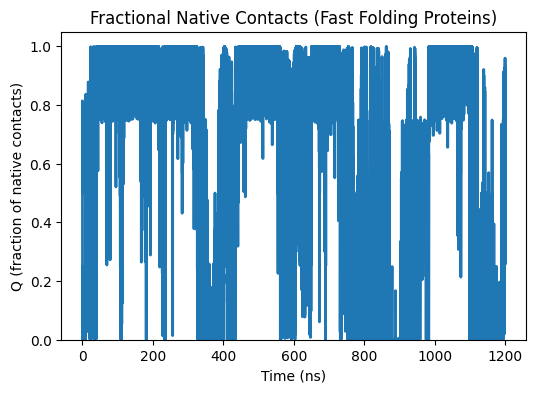

[0.5        0.37709904 0.7728845  ... 0.509055   0.6238996  0.42950186]
[0.00000e+00 1.00000e-02 2.00000e-02 ... 1.19998e+03 1.19999e+03
 1.20000e+03]
[[  4 122]
 [ 25 122]
 [ 25 146]
 [ 46 146]]


In [ ]:
q, t, pairs = plot_fractional_contacts_ffp(traj, "/home/shpark/prj-mlcv/lib/bioemu/opes/data/CLN025/folded.pdb", show=True)

print(q)
print(t)
print(pairs)

In [13]:
simulation_traj = md.load(
	"/home/shpark/prj-mlcv/lib/bioemu/opes/data/CLN025/folded.pdb"
)
simulation_xyz = torch.load(
	"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-pos.pt"
).numpy()
simulation_traj.xyz = simulation_xyz
simuulation_view = nv.show_mdtraj(simulation_traj)
simuulation_view.add_representation("licorice", selection="protein")
simuulation_view

NGLWidget(max_frame=534742)

In [15]:
simulation_pdb = md.load_pdb(
    "/home/shpark/prj-mlcv/lib/bioemu/opes/data/CLN025/folded.pdb"
)
q, t, pairs = plot_fractional_contacts_ffp(simulation_traj, "/home/shpark/prj-mlcv/lib/bioemu/opes/data/CLN025/folded.pdb"
, show=True)

print(q)
print(t)
print(pairs)

ValueError: unitcell_vectors must be shape (534743, 3, 3). You supplied  (1, 3, 3)